#Импорт библиотек

In [1]:
# установка дополнительной библиотеки
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.3 MB/s eta 0:00:00


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd # работа с таблицами
import numpy as np # математические вычисления
from scipy import stats # статистические методы
import matplotlib
import matplotlib.pyplot as plt # визуализация данных

from dateutil.parser import parse # парсер даты

from statsmodels.tsa.seasonal import seasonal_decompose # оценка сезонности
from scipy.stats import normaltest # критерий Д'Агостино K^2, оценка данных на распределение Гаусса
from statsmodels.tsa.statespace.tools import diff  # разность рядов просто и/или сезонно вдоль нулевой оси
from statsmodels.tsa.arima_model import ARMAResults,ARIMAResults # Получить результаты после fit ARMA, ARIMA
from statsmodels.tsa.arima.model import ARIMA # Построить модель ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX # Построить модель SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # plot_acf график автокорреляции, plot_pacf частичной автокорреляции
from statsmodels.graphics.tsaplots import month_plot,quarter_plot # график сезонности данных по месяцам, кварталам
from pandas.plotting import lag_plot # график лага

from statsmodels.tsa.stattools import adfuller # тест Дики-Фуллера

from sklearn.metrics import mean_squared_error # метрика качества MSE
from statsmodels.tools.eval_measures import rmse  # метрика качества Квадратный корень из MSE

from pmdarima import auto_arima # автоматический подбор параметров

In [3]:
plt.rcParams["figure.figsize"] = (14,7) # размер графиков

plt.style.use('fivethirtyeight') # стиль графиков

In [4]:
def adf_test(series,title=''):
  '''
  тест Дики-Фуллера
  0 гипотеза: ряд данных не стационарен
  альтернативная гипотеза: ряд данных стационарен
  Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда
  @param series - значения ряда
  @param title - заголовок ряда
  '''

  result = adfuller(series.dropna(),autolag='AIC')

  labels = ['ADF тест','p-value','# lags used','# наблюдения']
  out = pd.Series(result[0:4],index=labels)

  for key,val in result[4].items():
      out[f'критическое значение ({key})']=val

  print(out.to_string())

  if result[1] <= 0.05:
      print("Сильные доказательства против нулевой гипотезы")
      print("Отменяем 0 гипотезу")
      print("Данные стационарны")
  else:
      print("Слабые доказательства против нулевой гипотезы")
      print("Не отменяем 0 гипотезу")
      print("Данные не стационарны")

#Загрузка данных и первичная подготовка

In [5]:
# загрузка данных
df= pd.read_csv("/content/drive/MyDrive/power_usage_2016_to_2020.csv", parse_dates=True)
df

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday
...,...,...,...,...
35947,2020-07-07 19:00:00,1.307,1,weekday
35948,2020-07-07 20:00:00,2.872,1,weekday
35949,2020-07-07 21:00:00,2.138,1,weekday
35950,2020-07-07 22:00:00,2.199,1,weekday


In [6]:
#Удаляю метку времени
df["StartDate"] = df["StartDate"].str.split().str[0]
df=df.drop_duplicates(subset = 'StartDate')
#Делаю индексом поле с датой, так же его нужно перевести в формат даты.
#Удаляю поле 'notes' и 'day_of_week'
df['StartDate']=pd.to_datetime(df['StartDate'])
df=df.set_index('StartDate')
df.drop(['notes'], axis= 1 , inplace= True )
df.drop(['day_of_week'], axis= 1 , inplace= True )
df.head(5)


<ipython-input-6-72c46c59c5de>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StartDate']=pd.to_datetime(df['StartDate'])


,Value (kWh)
StartDate,
2016-01-06,1.057
2016-02-06,1.281
2016-03-06,0.736
2016-04-06,0.636
2016-05-06,1.033


In [7]:
# удаляю пропущенные значения
df.dropna(inplace=True)

In [8]:
len(df)

1498

In [9]:
df.sort_index()

,Value (kWh)
StartDate,
2016-01-06,1.057
2016-01-07,1.572
2016-01-08,2.228
2016-01-09,1.484
2016-01-10,0.742
...,...
2020-12-02,0.489
2020-12-03,0.416
2020-12-04,0.345


#Анализ временного ряда

In [10]:
df.index # Хотя выше я пытаюсь отсортировать по индексу, всё равно получаю freq=None на что ругается seasonal_decompose и дальнейшее обучение происходит с некоторыми ошибками, к сожалению с этим так и не смог разобраться!!!

DatetimeIndex(['2016-01-06', '2016-02-06', '2016-03-06', '2016-04-06',
               '2016-05-06', '2016-06-06', '2016-07-06', '2016-08-06',
               '2016-09-06', '2016-10-06',
               ...
               '2020-06-28', '2020-06-29', '2020-06-30', '2020-01-07',
               '2020-02-07', '2020-03-07', '2020-04-07', '2020-05-07',
               '2020-06-07', '2020-07-07'],
              dtype='datetime64[ns]', name='StartDate', length=1498, freq=None)

In [11]:
df.describe() #дескриптивная аналитики

,Value (kWh)
count,1498.000000
mean,0.955613
std,0.755900
min,0.151000
25%,0.343000
50%,0.696000
75%,1.378750
max,4.484000


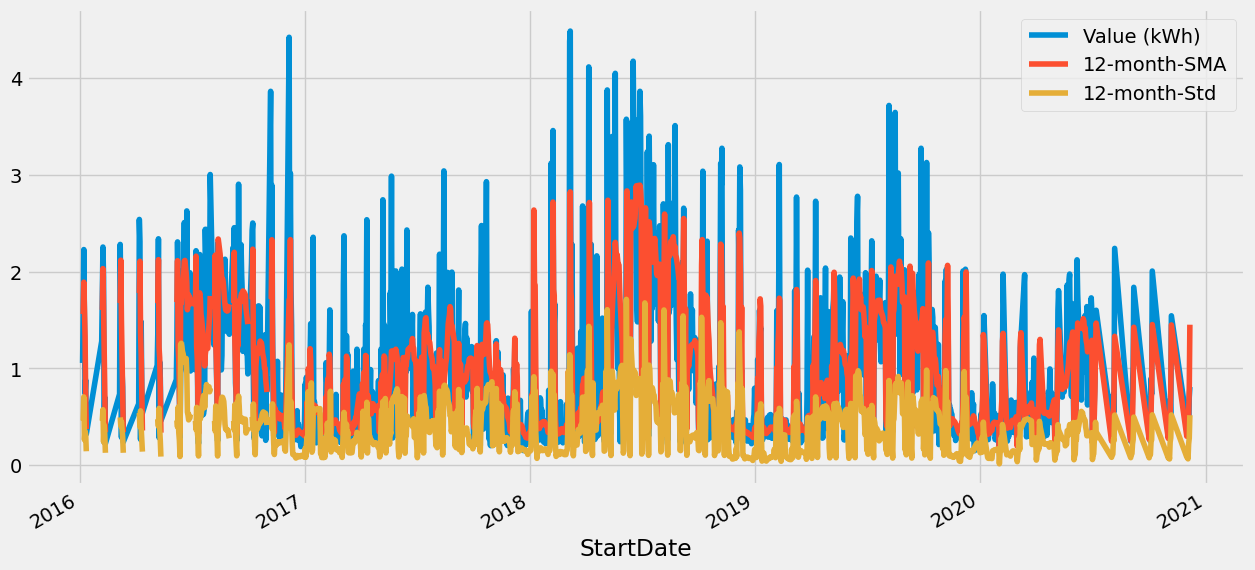

In [12]:
#дескриптивная аналитики, расчёт скользящего окна
df['12-month-SMA'] = df['Value (kWh)'].rolling(window=12).mean()
df['12-month-Std'] = df['Value (kWh)'].rolling(window=12).std()

df[['Value (kWh)','12-month-SMA','12-month-Std']].plot();

In [13]:
# наглядно показываем какие есть столбцы
df.columns

Index(['Value (kWh)', '12-month-SMA', '12-month-Std'], dtype='object')

In [14]:
df['Value (kWh)']

StartDate
2016-01-06    1.057
2016-02-06    1.281
2016-03-06    0.736
2016-04-06    0.636
2016-05-06    1.033
              ...  
2020-03-07    1.313
2020-04-07    0.807
2020-05-07    1.804
2020-06-07    1.769
2020-07-07    1.601
Name: Value (kWh), Length: 1498, dtype: float64

In [ ]:
# сезонная декомпозиция
ssn= seasonal_decompose(df['Value (kWh)'], model="add")
fig = ssn.plot()
fig.set_size_inches((14, 10))
fig.tight_layout()
plt.show()

ValueError: ignored

In [ ]:
# построим новый вид графика
month_plot(df['Value (kWh)']);

AttributeError: ignored

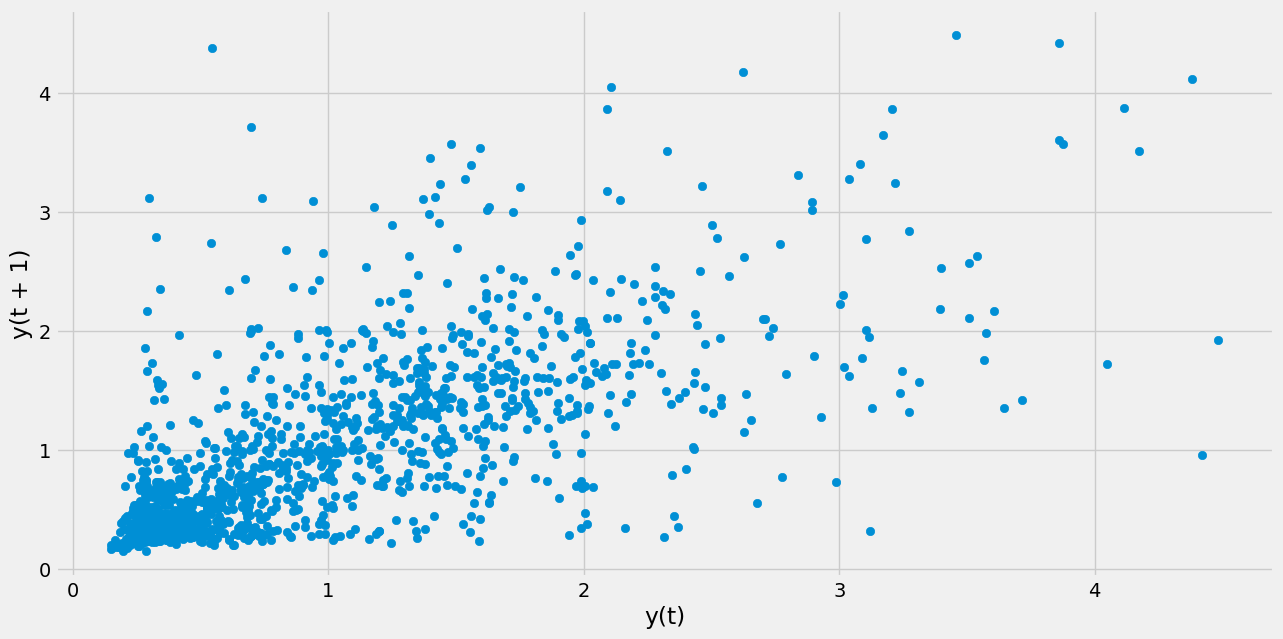

In [ ]:
# автокорреляция значения t+1 (следующий лаг времени) от текущего (t)
lag_plot(df['Value (kWh)']);

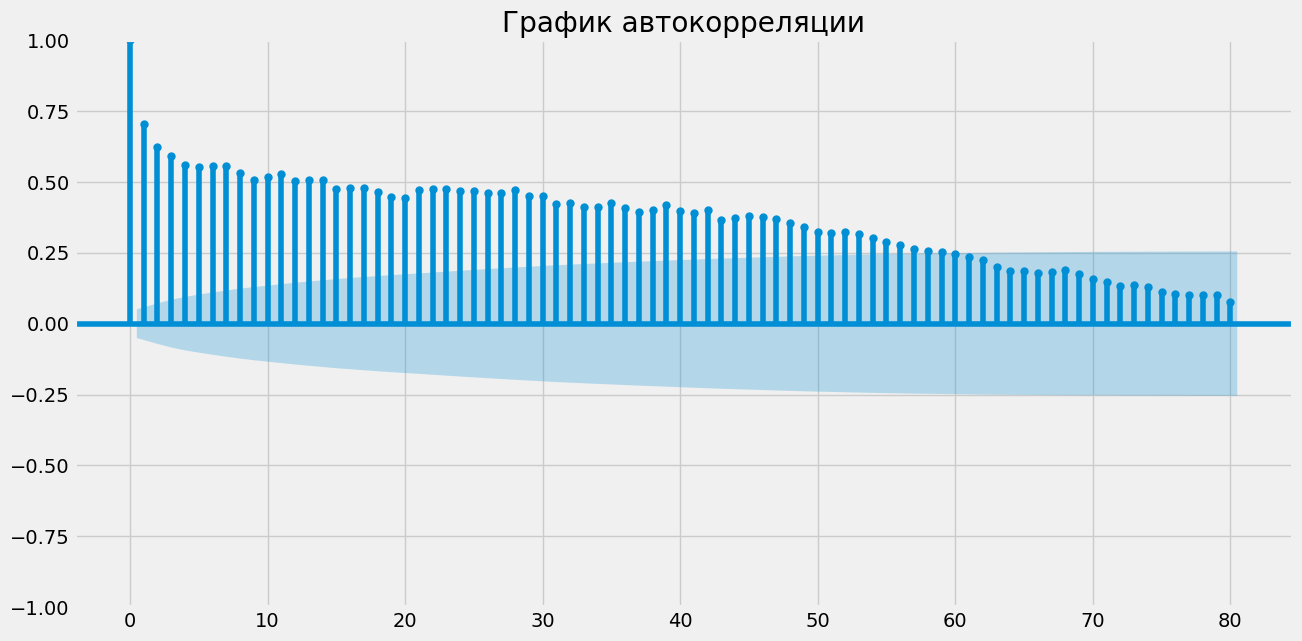

In [ ]:
# ACF
title = 'График автокорреляции'
lags = 80 # оптимальное значение (т.к. большой времнной период)
plot_acf(df["Value (kWh)"],title=title,lags=lags);

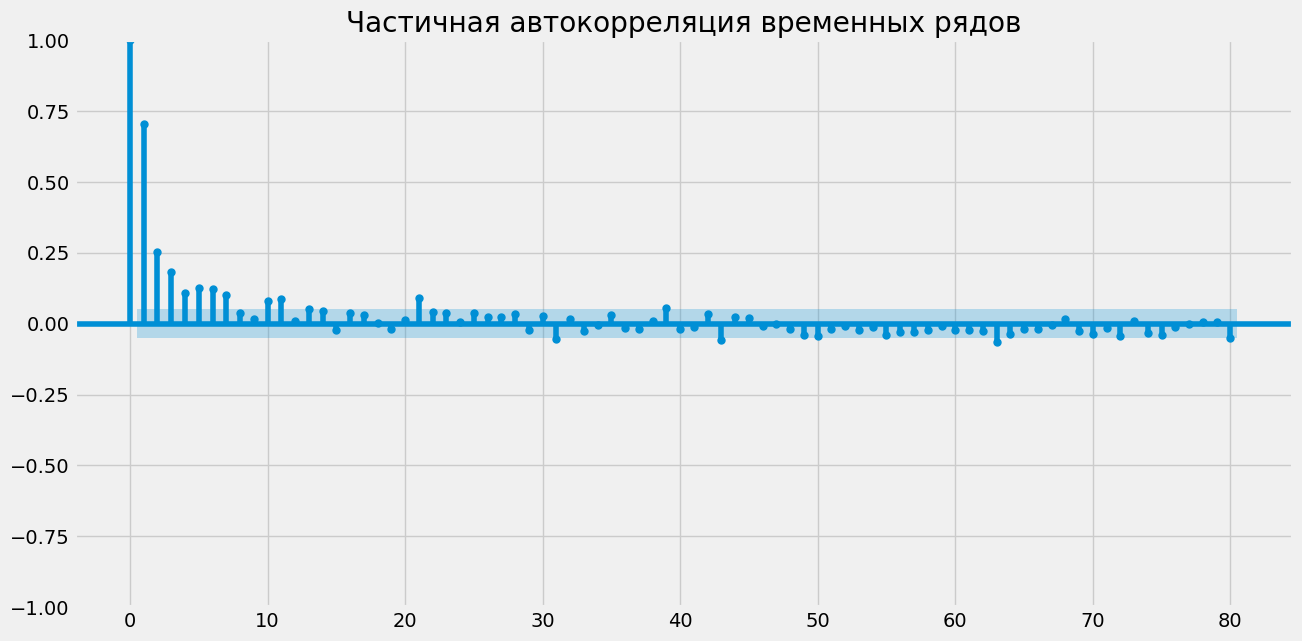

In [ ]:
# PACF - функция частичной автокорреляции дает частичную корреляцию стационарного временного ряда с его собственными запаздывающими значениями
title = 'Частичная автокорреляция временных рядов'
lags = 80
plot_pacf(df["Value (kWh)"],title=title,lags=lags);

#Cтационарность

In [15]:
# тест на стационарность, p-value < 0.05
adf_test(df['Value (kWh)'])

ADF тест                        -2.909167
p-value                          0.044292
# lags used                     22.000000
# наблюдения                  1475.000000
критическое значение (1%)       -3.434791
критическое значение (5%)       -2.863501
критическое значение (10%)      -2.567814
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


<Axes: xlabel='StartDate'>

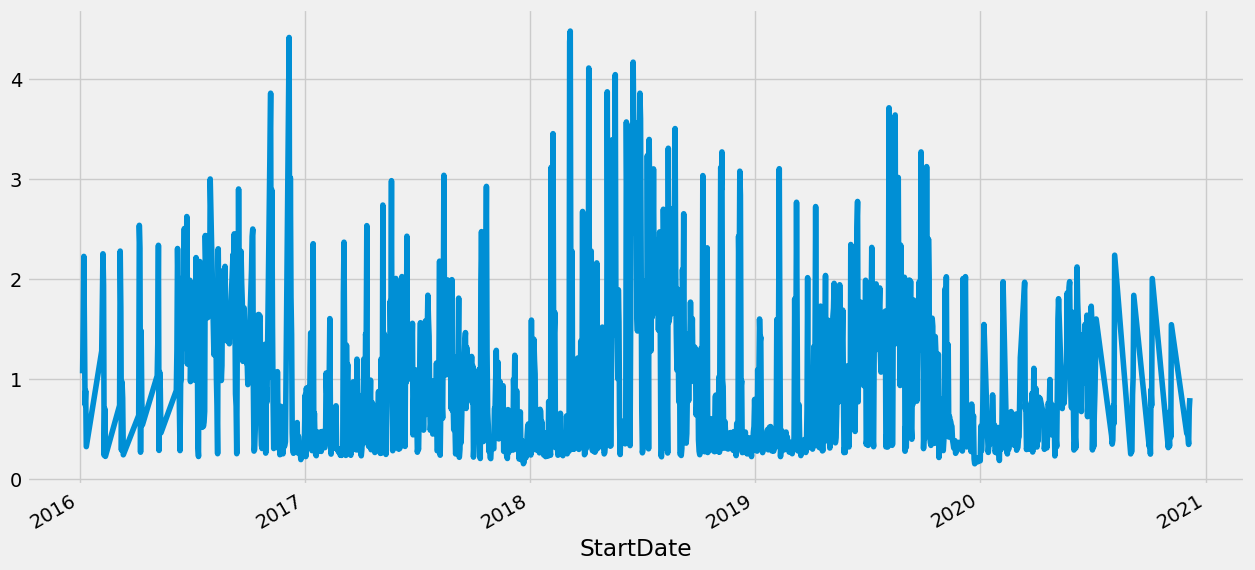

In [ ]:
df["Value (kWh)"].plot()

<Axes: xlabel='StartDate'>

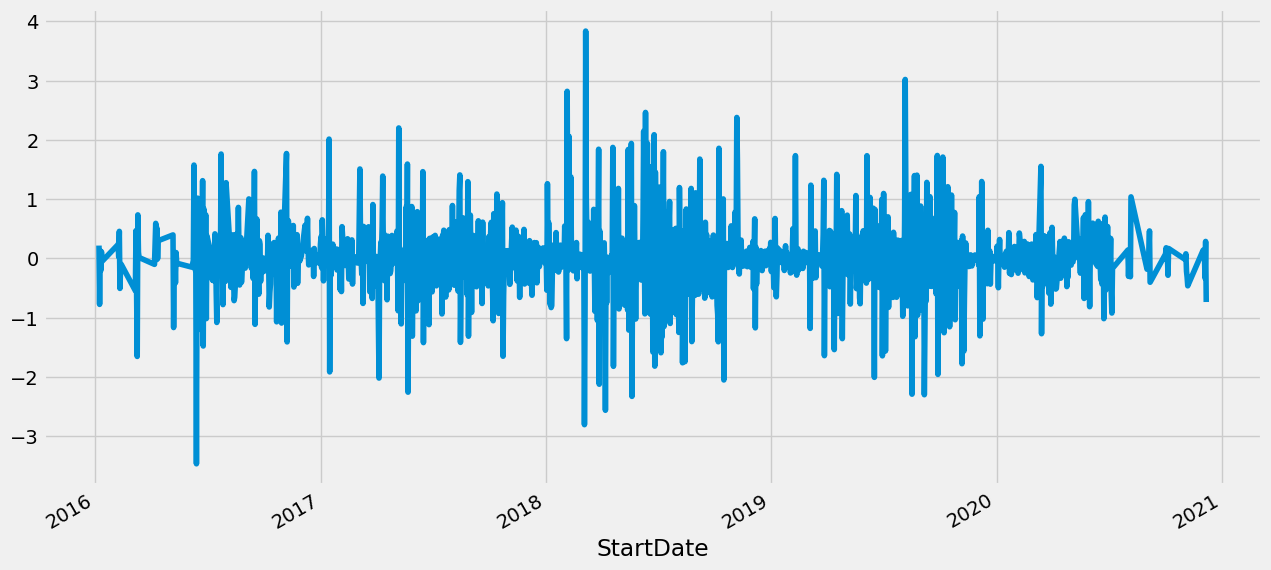

In [ ]:
# сконвертируем нестационарный ряд в стационарный
# Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда
df["difference_1"]= diff(df["Value (kWh)"], k_diff=1)
df["difference_1"].plot()

In [ ]:
adf_test(df["difference_1"])

ADF тест                     -1.255935e+01
p-value                       2.119460e-23
# lags used                   2.100000e+01
# наблюдения                  1.475000e+03
критическое значение (1%)    -3.434791e+00
критическое значение (5%)    -2.863501e+00
критическое значение (10%)   -2.567814e+00
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


<Axes: xlabel='StartDate'>

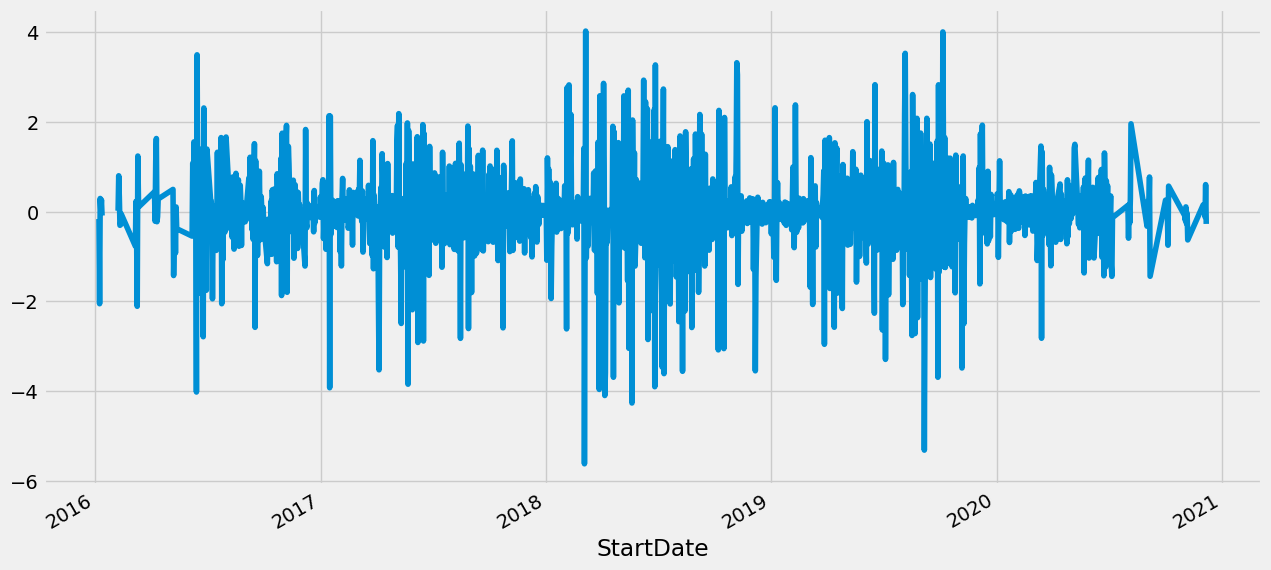

In [ ]:
df["difference_2"]= diff(df["Value (kWh)"], k_diff=2)
df["difference_2"].plot()

In [ ]:
adf_test(df["difference_2"])

ADF тест                     -1.523732e+01
p-value                       5.220724e-28
# lags used                   2.400000e+01
# наблюдения                  1.471000e+03
критическое значение (1%)    -3.434803e+00
критическое значение (5%)    -2.863507e+00
критическое значение (10%)   -2.567817e+00
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


<Axes: xlabel='StartDate'>

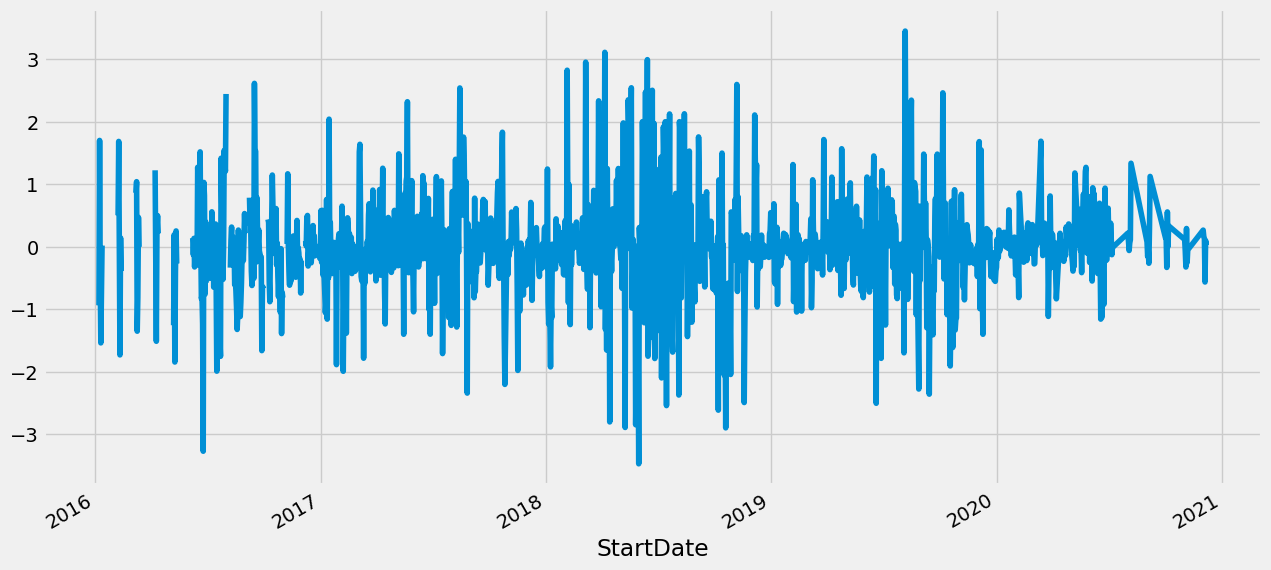

In [ ]:
# стационарность после сезонной разности
df["difference_seasonal"]= diff(df["Value (kWh)"], k_diff=0,k_seasonal_diff= 1,seasonal_periods= 12)
df["difference_seasonal"].plot()

In [ ]:
adf_test(df["difference_seasonal"])

ADF тест                     -9.308063e+00
p-value                       1.067396e-15
# lags used                   2.400000e+01
# наблюдения                  1.461000e+03
критическое значение (1%)    -3.434834e+00
критическое значение (5%)    -2.863520e+00
критическое значение (10%)   -2.567824e+00
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


#Подготовка данных

In [ ]:
len(df)

1498

In [ ]:
# разделим на тестовый и тренировочный набор данных
TEST_SIZE = 125
train= df.iloc[len(df)-TEST_SIZE:]
test= df.iloc[:len(df)-TEST_SIZE]

In [ ]:
print(len(train))
print(len(test))

125
1373


In [ ]:
# найдем порядок p,d,q
# ARIMA: обучение модели без сезонной составляющей
auto_arima_results= auto_arima(train["Value (kWh)"],
           start_p=0,
           start_q=0,
           max_p=3,
           max_q=3,
           m=1,
           d=None,
           seasonal=False,
           start_P=0,
           D=0,
           trace=True,
           error_action='ignore',
           stepwise=True)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=146.492, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=133.489, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=105.203, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=144.555, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=99.543, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=99.716, Time=0.61 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=100.996, Time=0.49 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=101.316, Time=0.73 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=102.011, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 3.624 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 -45.771
Date:                Sun, 26 Nov 2023   AIC                             99.543
Time:                        09:31:47   BIC                            110.824
Sample:                             0   HQIC                           104.125
                                - 125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0091      0.003      3.097      0.002       0.003       0.015
ma.L1         -0.6470      0.092     -7.007      0.000      -0.828      -0.466
ma.L2         -0.2840      0.081     -3.494      0.000      -0.443      -0.125
sigma2         0.1207      0.011     11.274      0.000       0.100       0.142
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                57.38
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             1.02
Prob(H) (two-sided):                  0.16   Kurtosis:                         5.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

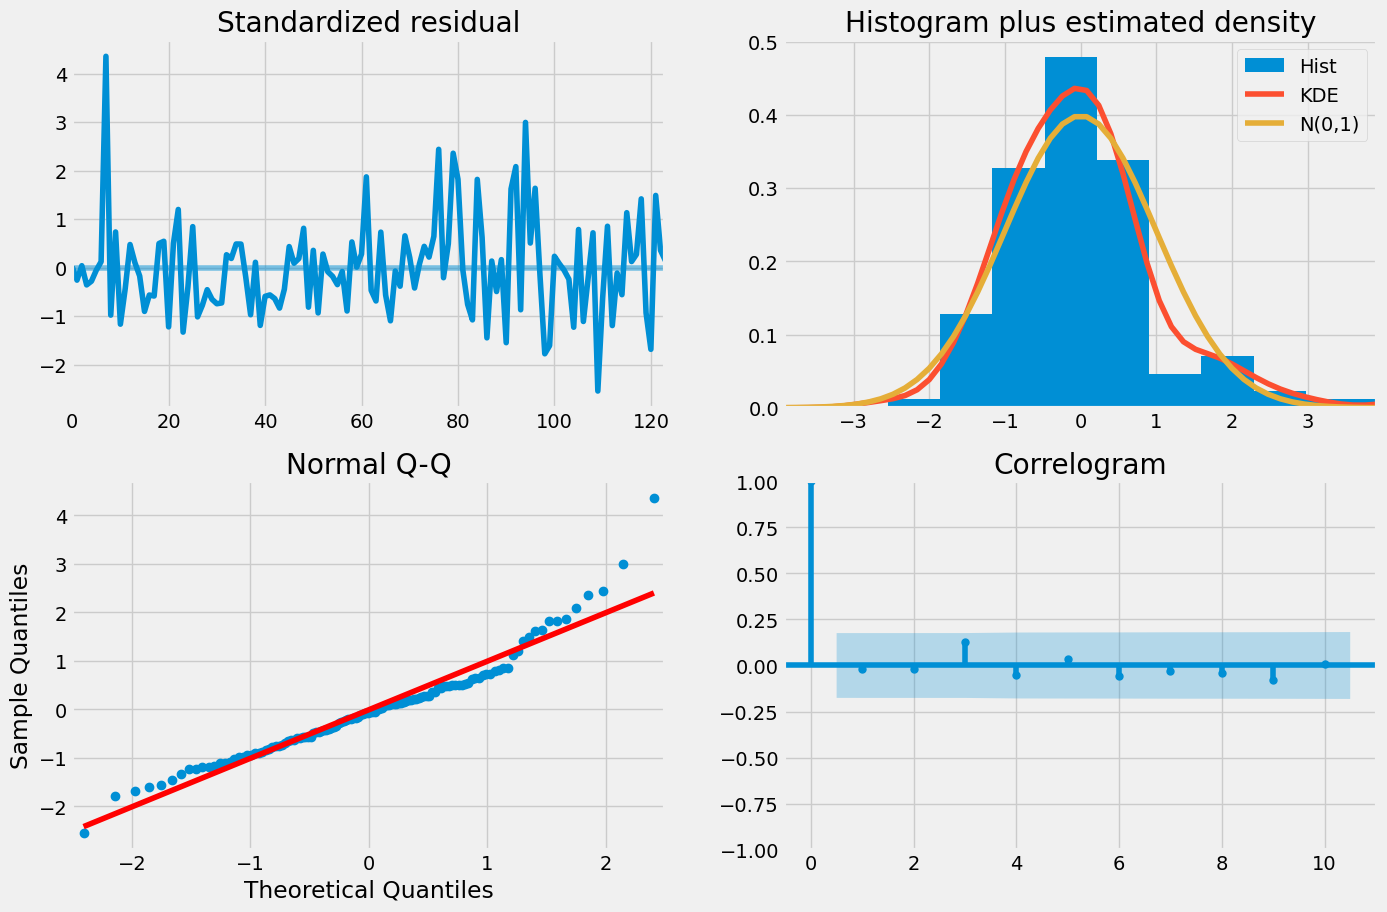

In [ ]:
# интерпретация ARIMA модели в виде графиков
auto_arima_results.plot_diagnostics(figsize=(15,10))
plt.show()

#Построение моделей и прогназирования

##ARIMA

In [ ]:
# обучим модель ARIMA используя p,d,q из полученного результата по auto_arima
arima_model= ARIMA(train["Value (kWh)"], order= (2,1,2), freq=train.index.inferred_freq)
arima_model_fit= arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [ ]:
normaltest(arima_model_fit.resid)
# если p-value не менее 0.05 , это означает, что остатки нормально распределены

NormaltestResult(statistic=23.66779872093179, pvalue=7.2544218805171154e-06)

In [ ]:
# сделаем прогноз на test наборе данных
start= len(train)
end= len(train) + len(test) -1
pred= arima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("ARIMA predictions")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


#Не понимаю откуда берутся такие года. Всё перепробовал никак!

<Axes: title={'center': 'Актуальность и Прогноз для Test набора данных'}, xlabel='StartDate'>

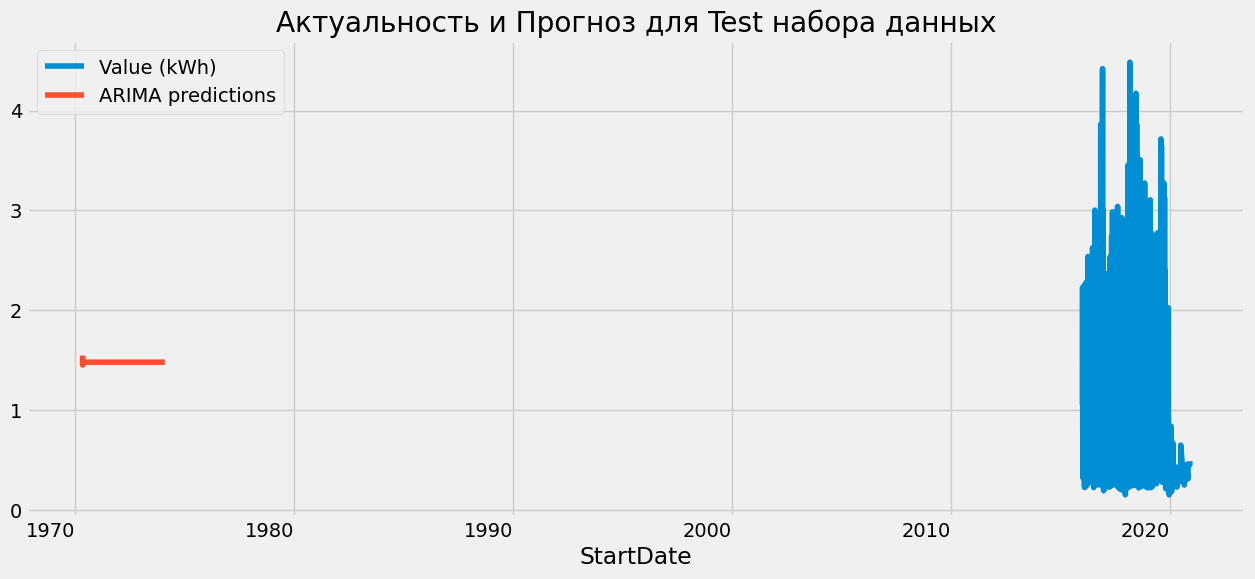

In [ ]:
title= "Актуальность и Прогноз для Test набора данных"
test["Value (kWh)"].plot(title=title, legend=True);
pred.plot(legend=True)
# Не понимаю откуда берутся тестовые значения за пределами моих данных.

In [ ]:
# оценим модель по штрафным баллам
mse= mean_squared_error(test["Value (kWh)"],pred)
rmse_arima= rmse(test["Value (kWh)"], pred)

print(f"RMSE= {rmse_arima} \n")
print(f"MSE= {mse}")

RMSE= 0.9336889957028189 

MSE= 0.8717751406965386


##SARIMA

In [ ]:
# найдем порядок p,d,q
# ARIMA: обучение модели с сезонной составляющей
smodel = auto_arima(train["Value (kWh)"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=148.488, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=146.492, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=135.453, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=106.973, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=144.555, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=105.203, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=106.986, Time=0.37 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=108.912, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=99.543, Time=0.13 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=101.385, Time=0.33 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=101.383, Time=0.31 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=103.381, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=99.716, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 -45.771
Date:                Sun, 26 Nov 2023   AIC                             99.543
Time:                        09:32:41   BIC                            110.824
Sample:                             0   HQIC                           104.125
                                - 125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0091      0.003      3.097      0.002       0.003       0.015
ma.L1         -0.6470      0.092     -7.007      0.000      -0.828      -0.466
ma.L2         -0.2840      0.081     -3.494      0.000      -0.443      -0.125
sigma2         0.1207      0.011     11.274      0.000       0.100       0.142
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                57.38
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             1.02
Prob(H) (two-sided):                  0.16   Kurtosis:                         5.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# обучим модель
sarima_model= SARIMAX(train["Value (kWh)"], order= (3,0,0), seasonal_order= (0,1,0,12), freq=train.index.inferred_freq)
sarima_model_fit= sarima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# сделаем пронозы на Test данных
start= len(train)
end= len(train) + len(test) -1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: title={'center': 'Актуальность и прогноз для Test данных'}, xlabel='StartDate'>

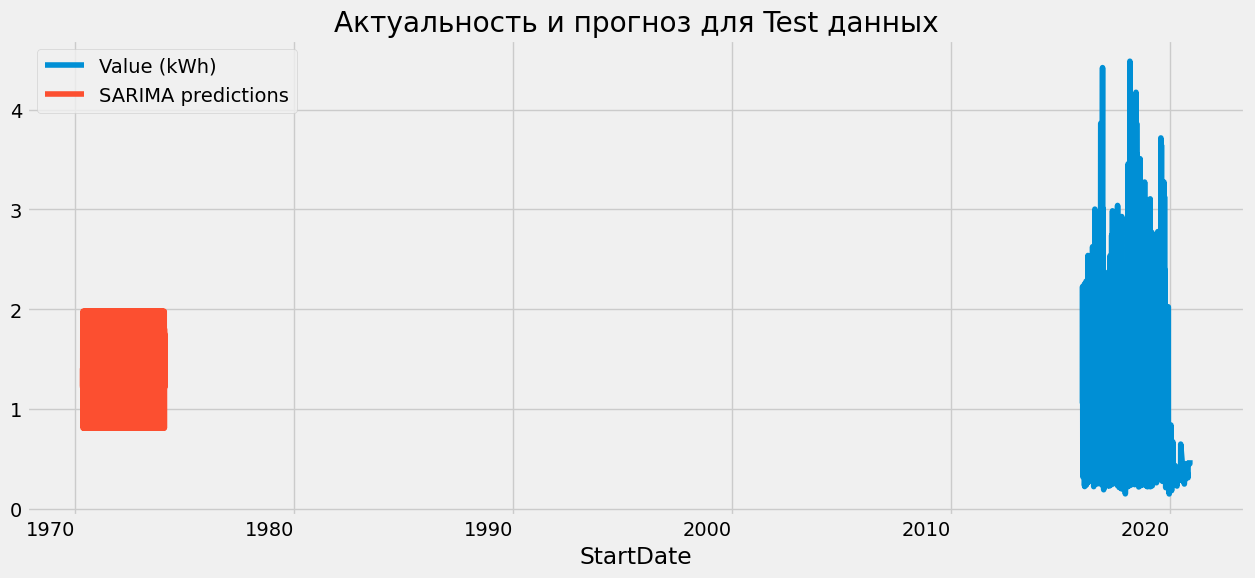

In [ ]:
# построим прогноз
title= "Актуальность и прогноз для Test данных"
test["Value (kWh)"].plot(title= title, legend=True)
pred.plot(legend=True)

In [ ]:
# оценим модель
mse= mean_squared_error(test["Value (kWh)"],pred)
rmse_sarima= rmse(test["Value (kWh)"], pred)

print(f"RMSE= {rmse_sarima} \n")
print(f"MSE= {mse}")

RMSE= 0.9962948237974886 

MSE= 0.9926033759256687


In [ ]:
# подсчитаем сезонный индекс
result_mul = seasonal_decompose(train["Value (kWh)"],
                                model='multiplicative',
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

ValueError: ignored

In [ ]:
result_mul

NameError: ignored

In [ ]:
# соединим его с Train данными
train['month'] = train.index.month
train2 = pd.merge(train, seasonal_index, how='left', on='month')

train2.index = train.index  # переопределим первичный индекс

<ipython-input-149-259347552397>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month'] = train.index.month


NameError: ignored

In [ ]:
train2

NameError: ignored

In [ ]:
# соединим его с Test данными
test['month'] = test.index.month
test2 = pd.merge(test, seasonal_index, how='left', on='month')
test2.index = test.index  # переопределим первичный индекс

<ipython-input-140-c35e0427758f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['month'] = test.index.month


NameError: ignored

In [ ]:
test2

NameError: ignored

##SARIMAX

In [16]:
# SARIMAX модель
sxmodel = auto_arima(train2["Value (kWh)"],
                     exogenous=train2[['seasonal']],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

sxmodel.summary()

NameError: ignored

In [ ]:
# обучение модели
sarimax_model= SARIMAX(train2["Value (kWh)"], order= (1,1,0), seasonal_order= (1,0,0,12),exog=train2[['seasonal']], freq=train.index.inferred_freq)
sarimax_model_fit= sarimax_model.fit()

NameError: ignored

In [ ]:
# прогнозы на Test
start= len(train)
end= len(train) + len(test) -1
pred= sarimax_model_fit.predict(start=start, end=end, dynamic=False, typ="levels",exog=test2[['seasonal']]).rename("SARIMAX with Exog")

NameError: ignored

<Axes: title={'center': 'Актуальность и прогноз для Test данных'}, xlabel='StartDate'>

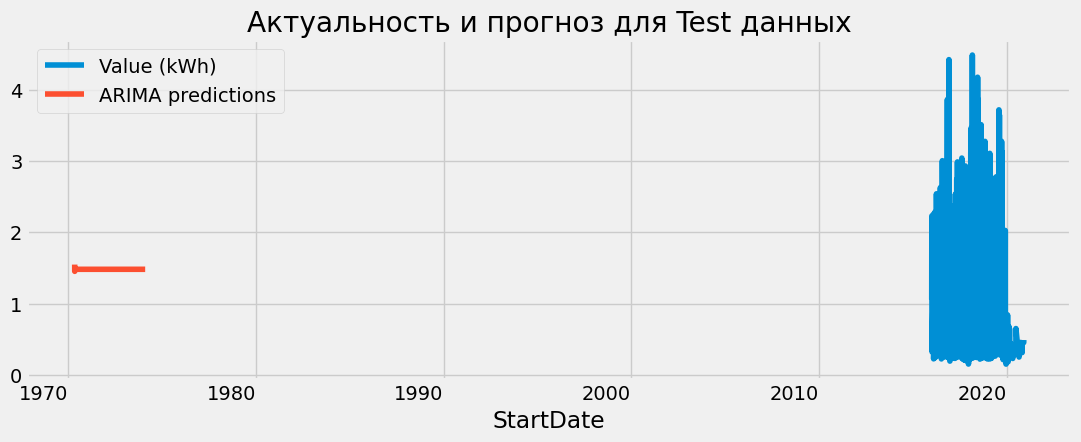

In [ ]:
title= "Актуальность и прогноз для Test данных"
test["Value (kWh)"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

#Оценка модели

In [ ]:
# оценка модели
mse= mean_squared_error(test["Value (kWh)"],pred)
rmse_sarimax= rmse(test["Value (kWh)"], pred)

print(f"Root Mean Square is {rmse_sarimax} \n")
print(f"Mean Square Error is {mse}")

Root Mean Square is 1.5329938489594723 

Mean Square Error is 2.3500701409475777


In [ ]:
# перетренируем модель на всем объеме данных для прогноза
model= SARIMAX(df["Value (kWh)"], order= (3,0,0), seasonal_order= (0,1,0,12), freq=train.index.inferred_freq)
results= model.fit()

start= len(df)
end= len(df) + len(test) -1

pred= results.predict(start=start, end=end, dynamic=False, typ="levels").rename("Future Forecasts")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

<Axes: title={'center': 'Актуальность и Прогноз для Test набора данных'}, xlabel='StartDate'>

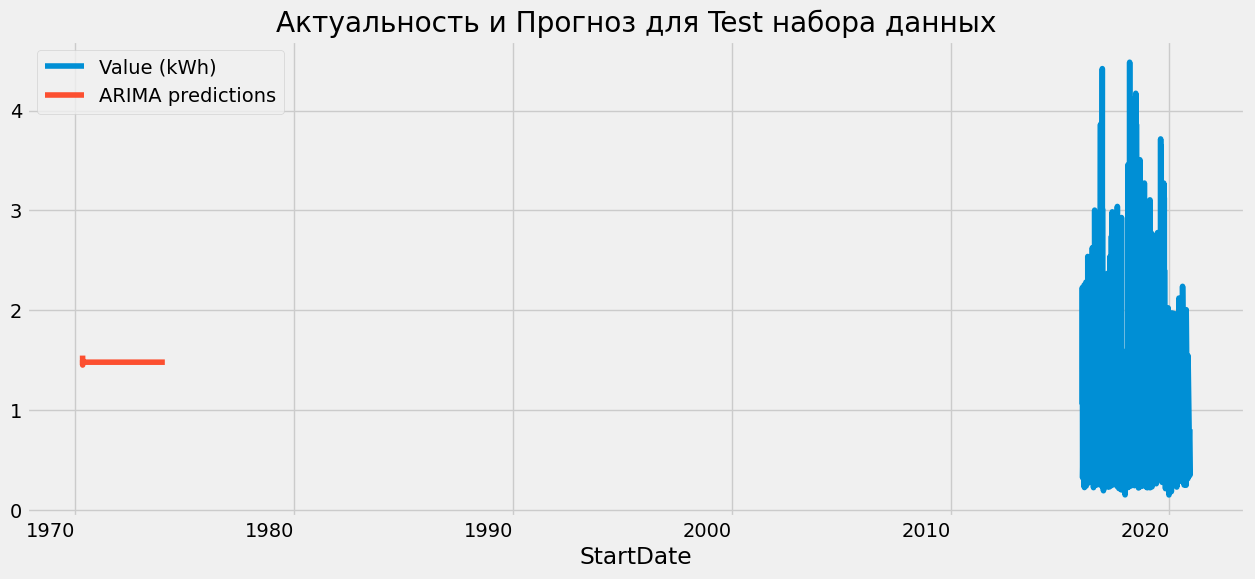

In [ ]:
# прогноз
df["Value (kWh)"].plot(title= title, legend=True)
pred.plot(legend=True)

In [ ]:
# оценка модели
mse= mean_squared_error(test["Value (kWh)"],pred)
rmse_sarimax= rmse(test["Value (kWh)"], pred)

print(f"Root Mean Square is {rmse_sarimax} \n")
print(f"Mean Square Error is {mse}")

Root Mean Square is 0.9724530826476506 

Mean Square Error is 0.9456649979509185


#Идея в том что бы предсказывать потребление электроэнергии на определённой территории. К сожалению так и не получилось разобраться с реализацией.